In [11]:
import itertools
import yaml
from yaml.loader import SafeLoader
import mlflow
import mlflow.pyfunc
import joblib
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata
from sdv.single_table import TVAESynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir('/home/onyxia/work/synthetic-data-sdc/')
os.environ["MLFLOW_TRACKING_URI"] = "https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/" 

In [12]:
variables = ['sex','age','agegr','placesize','edu','socprof','marital','ls','depress','trust','trustfam','trustneigh','sport','nofriend','smoke','alcabuse','alcsol','wkabint','englang','height','weight','bmi']

In [13]:
original = pd.read_csv('SDV/df_original.csv', names = variables)

In [14]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(original)
metadata

{
    "columns": {
        "sex": {
            "sdtype": "categorical"
        },
        "age": {
            "sdtype": "numerical"
        },
        "agegr": {
            "sdtype": "categorical"
        },
        "placesize": {
            "sdtype": "categorical"
        },
        "edu": {
            "sdtype": "categorical"
        },
        "socprof": {
            "sdtype": "categorical"
        },
        "marital": {
            "sdtype": "categorical"
        },
        "ls": {
            "sdtype": "categorical"
        },
        "depress": {
            "sdtype": "numerical"
        },
        "trust": {
            "sdtype": "categorical"
        },
        "trustfam": {
            "sdtype": "categorical"
        },
        "trustneigh": {
            "sdtype": "categorical"
        },
        "sport": {
            "sdtype": "categorical"
        },
        "nofriend": {
            "sdtype": "numerical"
        },
        "smoke": {
            "sdtype": "categoric

In [15]:
with open("SDV/config_tvae_2.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

class TVAEWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))

remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'
run_name = 'tvae_jj'

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name):
    for param_key, param_value in config.items():
        if param_key != 'mlflow':
            mlflow.log_param(param_key, param_value)
    mlflow.log_param('run_name', run_name)

    #Entraînement
    start_time = time.time()
    tvae = TVAESynthesizer(metadata,
                           verbose=True,
                           compress_dims=config['compress_dims'],
                           decompress_dims=config['decompress_dims'],
                           batch_size=config['batch_size'],
                           epochs = config['epochs'])
    tvae.fit(original)
    end_time = time.time()
    
    elapsed_time = end_time - start_time
    mlflow.log_metric("elapsed_time", elapsed_time)
    print(f"Temps pris entraîner le modèle : {elapsed_time} secondes")
    
    params_tvae = tvae.get_parameters()
   

    # Log des paramètres du modèle
    for param_key, param_value in params_tvae.items():
        with mlflow.start_run(nested=True):
            mlflow.log_param(param_key, param_value)

    loss_by_epoch = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean().tolist()
    for epoch, loss in enumerate(loss_by_epoch):
        mlflow.log_metric("loss", loss, step=epoch+1)

    model_path = "tvae_model.pkl"
    joblib.dump(tvae, model_path)
    mlflow.pyfunc.log_model(
        artifact_path="tvae_model",
        python_model=TVAEWrapper(),
        artifacts={"model_path": model_path},
    )
    mlflow.log_artifact("SDV/config_tvae_2.yml", artifact_path = "config_model")
    
mlflow.end_run()

/opt/conda/lib/python3.12/site-packages/sdv/single_table/base.py:92: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
Loss: 29.249: 100%|██████████| 300/300 [25:52<00:00,  5.18s/it]
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run efficient-robin-206 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/3b70c99acdd84672b8106cc0794fdfb0.
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.


Temps pris entraîner le modèle : 1566.6616985797882 secondes


2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run flawless-swan-777 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/70ef8281f050404cb7d8d8f6deb1f63b.
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-mole-458 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/31fb79215d5d4731a32c17a6052ee778.
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/28 18:22:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run adventurous-koi-989 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/a1f1beba1ef543eca8f214cd4acb2627.
2

In [19]:
tvae.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'embedding_dim': 128,
 'compress_dims': [1024, 1024, 1024, 1024],
 'decompress_dims': [1024, 1024, 1024, 1024],
 'l2scale': 1e-05,
 'batch_size': 100,
 'verbose': True,
 'epochs': 300,
 'loss_factor': 2,
 'cuda': True}

In [27]:
loss_by_epoch = tvae.get_loss_values().groupby(['Epoch'])['Loss'].mean()
nb_epochs = config['epochs']

Text(0.5, 1.0, "Loss d'un modèle TVAE sur SD2011")

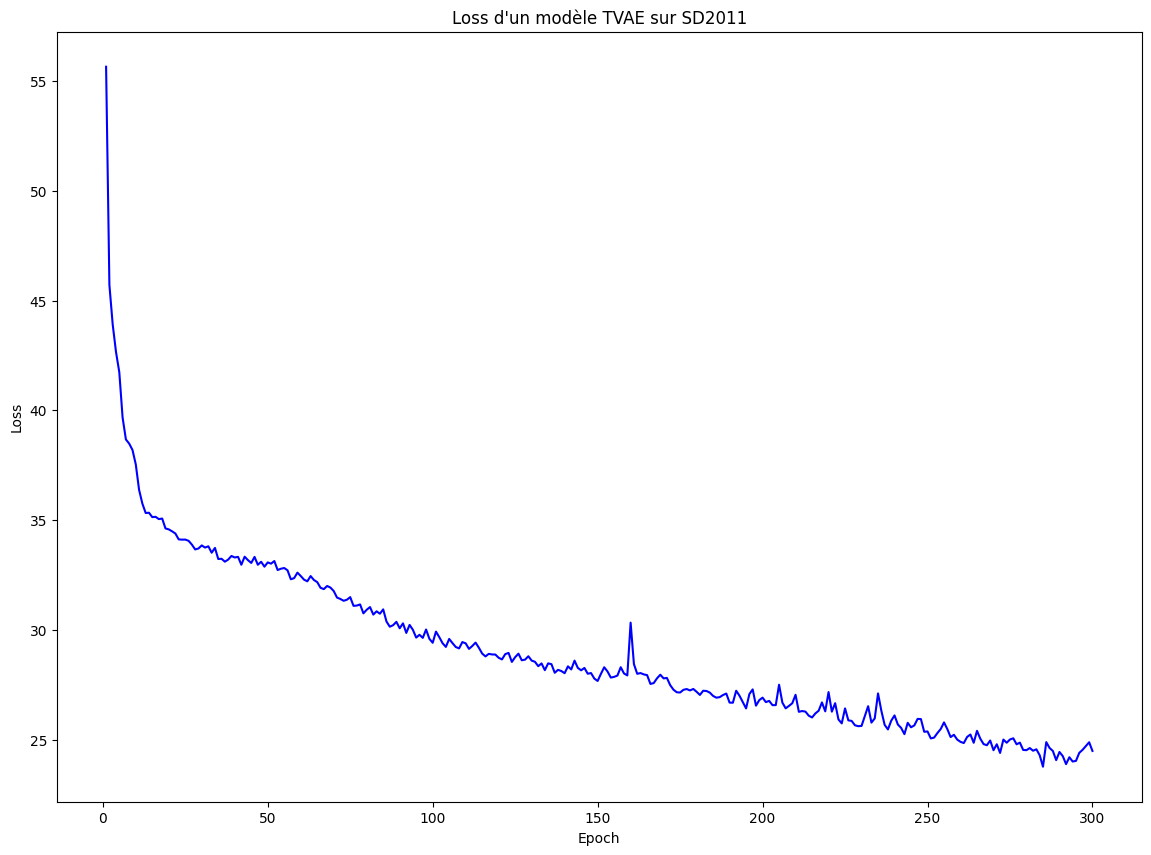

In [42]:
steps = range(1, nb_epochs+1)

plt.figure(figsize=(14, 10))

plt.plot(steps, loss_by_epoch, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011")
#plt.legend()S

Epoch
0      55.643644
1      45.709139
2      43.911029
3      42.659662
4      41.738037
         ...    
295    24.405432
296    24.543731
297    24.719252
298    24.888723
299    24.493433
Name: Loss, Length: 300, dtype: float64